In [2]:
import os
import re
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import kagglehub
from collections import Counter

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

# MAPPING DATASETS

In [5]:
# Map Kaggle and Mendeley labels to unified set
label_map = {
    "URTI": "URTI",
    "Healthy": "Healthy",
    "Asthma": "Asthma",
    "COPD": "COPD",
    "LRTI": "LRTI",
    "Pneumonia": "Pneumonia",
    "Bronchiectasis": "BRON",
    "Bronchiolitis": "BRON",
    "BRON": "BRON",
    "Lung Fibrosis":"Lung Fibrosis",
    "Plueral Effusion":"Plueral Effusion"
}

In [4]:
class Diagnosis():
  def __init__ (self, id, diagnosis, audio_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.audio_path = audio_path   

# CLEANING & PARSING: Mendeley Dataset

In [7]:
# extract labels for Mendeley dataset
path_mendeley = "audioDataMendeley/Audio files"

keep_upper = {"COPD", "BRON"}
diagnosis_list =[]

# Detect diagnosis text in the filename and format it properly.
def format_diagnosis_from_filename(filename):
    name, ext = os.path.splitext(filename)
    
    # Split on first underscore
    parts = name.split("_", 1)
    if len(parts) > 1:
        prefix, diag_segment = parts[0], parts[1]
        
        # Split the diagnosis segment by commas
        diag_parts = diag_segment.split(",")
        formatted_diag_parts = []
        for part in diag_parts:
            part_clean = part.strip()
            if part_clean.upper() in keep_upper:
                formatted_diag_parts.append(part_clean.upper())
            elif part_clean == "N":
                formatted_diag_parts.append("Healthy")
            else:
                formatted_diag_parts.append(part_clean.title())
        
        # Rejoin with commas
        new_diag_segment = ",".join(formatted_diag_parts)
        new_name = f"{prefix}_{new_diag_segment}"
    else:
        new_name = name
    
    return new_name + ext

# go through directory and only keep necessary files
mendeley_labels = []
data_mendeley = []
for c, file in enumerate(os.listdir(path_mendeley)):
    if file.endswith(".wav"):
        old_path = os.path.join(path_mendeley, file)

        if "heart failure" in file.lower() or "and" in file.lower():
            os.remove(old_path)
            continue

        new_filename = format_diagnosis_from_filename(file)
        new_path = os.path.join(path_mendeley, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)

        # make patient diagnosis csv
        filename_parts = new_filename.split("_")
        patient_id_pattern = r"\d+"

        # extract patient id and diagnosis from filename 
        match_id = re.search(patient_id_pattern,filename_parts[0])
        if match_id:
            patient_id_mendeley = int(match_id.group())

        diag_segment = filename_parts[1]
        patient_diagnosis_mendeley = diag_segment.split(",")[0].strip()
        
        data_mendeley.append([patient_id_mendeley,patient_diagnosis_mendeley])

        diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=patient_diagnosis_mendeley,
        audio_path=new_path
    ))
        
# export csv
patient_diagnosis_df_mendeley = pd.DataFrame(data_mendeley)
patient_diagnosis_df_mendeley.to_csv('audioDataMendeley/patient_diagnosis.csv', index=False)

# PARSING DATASET: Kaggle

In [8]:
# Download latest version of the database 
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /Users/katherinebeaty/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [9]:
# extract lables for kaggle dataset
# Path to patient diagnosis CSV
diagnosis_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")

audio_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/")
files_kaggle = []
for file in os.listdir(audio_path_kaggle):
    if file.endswith(".wav"):
        files_kaggle.append(file)

files_kaggle = sorted(files_kaggle)

In [10]:
diag_dict_kaggle = { 101 : "URTI"}  
diagnosis_kaggle = pd.read_csv(diagnosis_path_kaggle)
  
for index , row in diagnosis_kaggle.iterrows():
    diag_dict_kaggle[row.iloc[0]] = row.iloc[1]

# Add kaggle files to diagnosis list
for c, f in enumerate(files_kaggle):
    patient_id = int(f.split('_')[0])
    raw_label = diag_dict_kaggle.get(patient_id, "Unknown")
    diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=label_map.get(raw_label, "Unknown"),
        audio_path=os.path.join(audio_path_kaggle, f)
    ))

# FEATURE EXTRACTION

In [11]:
unique_labels = sorted(set(d.diagnosis for d in diagnosis_list))

# Create a mapping from label
to_index = {label: idx for idx, label in enumerate(unique_labels)}
to_index

{'Asthma': 0,
 'BRON': 1,
 'COPD': 2,
 'Healthy': 3,
 'LRTI': 4,
 'Lung Fibrosis': 5,
 'Plueral Effusion': 6,
 'Pneumonia': 7,
 'URTI': 8}

In [12]:
# Collect all audio files and diagnosises in sets
audio_paths = [s.audio_path for s in diagnosis_list]
labels = [to_index[s.diagnosis] for s in diagnosis_list]

### Base Model

In [13]:
def extract_basic_model_features(audio_paths, target_sr=22050):
    # Load all audio files and return the audio file path, data, sample rate, and duration
    # Data is audio time series
    features = []

    for audio_file in audio_paths:
        y, sr = librosa.load(audio_file, sr=target_sr)  # sample rate is none bc of frequent low-frequency

        # compute STFT for chroma + contrast
        stft = np.abs(librosa.stft(y))

        # compute 1D audio features
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40), axis=1)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr), axis=1)
        mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr), axis=1)
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr), axis=1)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr), axis=1)

        # concatenate all features into one 1D vector
        combined = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

        features.append(combined)

    # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension
    # Source: Appendix 2
    padded = padded[..., np.newaxis]  # shape: (samples, feature_length, 1) 

    return padded


### Data Augmented Model

In [19]:
def augment_audio(audio, sr, augmentation_type):
    if augmentation_type == 'noise':
        # generate an array of random numbers
        noise = np.random.randn(len(audio))
        # add noise to original audio
        audio = audio + 0.005 * noise
        # clip audio so values are within valid range (-1 to 1)
        audio = np.clip(audio, -1.0, 1.0)
    elif augmentation_type == 'pitch_shift':
        audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=2)
    elif augmentation_type == 'remix':
        # detect non-silent intervals
        intervals = librosa.effects.split(audio, top_db=20)
        # only remix if there are multiple intervals
        if len(intervals) > 1:  
            np.random.shuffle(intervals)
            audio = librosa.effects.remix(audio, intervals)
        audio = np.clip(audio, -1.0, 1.0)
    return audio

In [1]:
def extract_augmented_model_features(audio_paths,labels,target_sr=22050,augmentation_types=['noise', 'pitch_shift', 'time_stretch']):
    features = []
    new_labels = []

    # add original features to list + augmented features
    for i, audio_file in enumerate(audio_paths):

        y, sr = librosa.load(audio_file, sr=target_sr)  # sample rate is none bc of frequent low-frequency

        # data augmentation loop
        for aug in augmentation_types:
            y_aug = augment_audio(y.copy(), sr, aug)

            stft_aug = np.abs(librosa.stft(y_aug))
            mfccs = np.mean(librosa.feature.mfcc(y=y_aug, sr=sr, n_mfcc=40), axis=1)
            chroma = np.mean(librosa.feature.chroma_stft(S=stft_aug, sr=sr), axis=1)
            mel = np.mean(librosa.feature.melspectrogram(y=y_aug, sr=sr), axis=1)
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft_aug, sr=sr), axis=1)
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y_aug), sr=sr), axis=1)

            combined_aug = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))

            features.append(combined_aug)
            new_labels.append(labels[i])

    # convert feature list to array (samples, feature_length)
    features = np.array(features)

    # pad along feature axis to ensure equal length
    max_len = max(f.shape[0] for f in features)
    padded = np.zeros((len(features), max_len))

    for i, f in enumerate(features):
        padded[i, :len(f)] = f

    # add channel dimension 
    # Source: Appendix 2
    padded = padded[..., np.newaxis]
    new_labels = np.array(new_labels)

    return padded, new_labels

### Location Focused Model

In [13]:
def extract_location_metadata(filename):
# extract chest location of where recording was taken from
# important to note, some samples will not be looked at because they don't fit into mapping
    location_map = {
        'A': 'Anterior',
        'P': 'Posterior',
        'T': 'Trachea',
        'L': 'Lateral',
    }
    if 'mendeley' in filename.lower():
        parts = filename.split(',')
        location_code = parts[-3].strip()[0]
        return location_map.get(location_code,'Unknown')
    elif 'kaggle' in filename.lower():
        parts = filename.split('_')
        location_code = parts[-3][0]
        return location_map.get(location_code, 'Unknown')
    return 'Unknown'

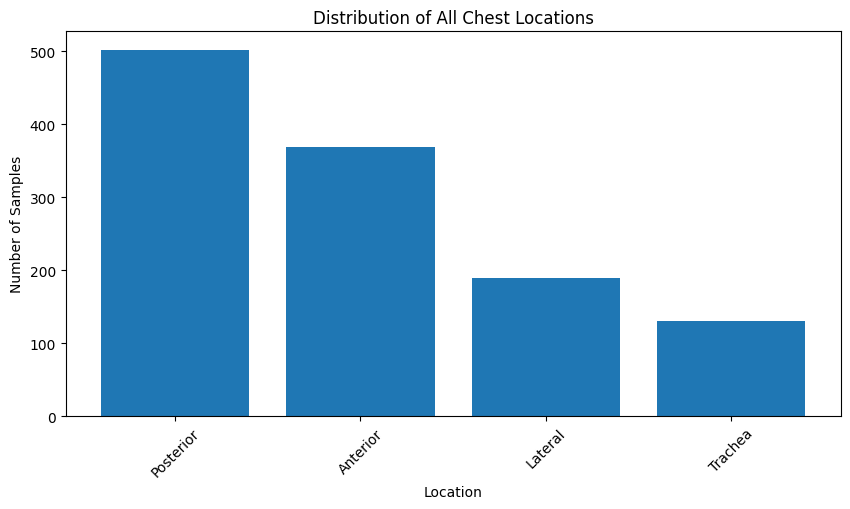

In [14]:
locations = [str(extract_location_metadata(f)) for f in audio_paths]
location_counts = Counter(locations)

# plot the distribution
plt.figure(figsize=(10,5))
plt.bar(location_counts.keys(), location_counts.values())
plt.xlabel('Location')
plt.ylabel('Number of Samples')
plt.title('Distribution of All Chest Locations')
plt.xticks(rotation=45)
plt.show()


We will not be using lateral, trachea, and unknown from our samples.

# PREPROCESSING

### Base and Augmented Model Splitting

In [14]:
# separate out the test set
train_val_paths, test_paths, y_train_val, y_test= train_test_split(
    audio_paths,labels, test_size=0.2, random_state=42, stratify=labels
)

# split the remaining paths into training and validation
train_paths, val_paths,y_train,y_val = train_test_split(
    train_val_paths, y_train_val,test_size=0.25, random_state=42, stratify=[labels[i] for i in range(len(train_val_paths))]
)

In [15]:
# set labels to variables
train_labels = to_categorical(y_train, num_classes=9)
val_labels = to_categorical(y_val, num_classes=9)
test_labels = to_categorical(y_test, num_classes=9)

### Base Model Features

In [24]:
base_features_train = extract_basic_model_features(train_paths)
base_features_val = extract_basic_model_features(val_paths)
base_features_test = extract_basic_model_features(test_paths)

In [25]:
print(base_features_train.shape) # 60%
print(base_features_val.shape) # 20%
print(base_features_test.shape) # 20%

(714, 193, 1)
(238, 193, 1)
(238, 193, 1)


### Data Augmented Model Features

In [26]:
# extract features from paths for augmentation
aug_features_train, aug_labels_train = extract_augmented_model_features(train_paths, y_train)

In [29]:
# Combine original and augmented features
aug_X_train = np.concatenate([base_features_train, aug_features_train], axis=0)
aug_y_train = np.concatenate([train_labels, to_categorical(aug_labels_train, num_classes=9)], axis=0)

# Keep validation and test sets as usual
aug_X_val = base_features_val
aug_y_val = val_labels

aug_X_test = base_features_test
aug_y_test = test_labels

In [30]:
print(aug_X_train.shape) 
print(aug_X_val.shape)
print(aug_X_test.shape)

(2856, 193, 1)
(238, 193, 1)
(238, 193, 1)


## Make CNN model bases

In [22]:
# Define model
# Source - Appendix 1
def create_cnn_model1(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='macro', threshold=0.5)
        ]
    )
    return model

In [ ]:
# Define model; change = added dropout between conv layers and adjusted dropout values
def create_cnn_model2(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='macro', threshold=0.5)
        ]
    )
    return model

In [ ]:
# Define model; change = F1 now using weighted instead of macro
def create_cnn_model3(input_shape,n_classes):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape))
    model.add(Conv1D(128, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(256, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(n_classes, activation='softmax'))

    # Compile model
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            tf.keras.metrics.F1Score(average='weighted', threshold=0.5)
        ]
    )
    return model

# Modeling

### Run Base Model

In [23]:
# model 1 + base training set
model_base_1 = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_1 = model_base_1.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - f1_score: 0.0922 - loss: 9.9196 - precision: 0.6132 - recall: 0.4930 - val_f1_score: 0.0912 - val_loss: 5.4870 - val_precision: 0.3908 - val_recall: 0.3908
Epoch 2/50
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step - f1_score: 0.1047 - loss: 3.7667 - precision: 0.4350 - recall: 0.4350

KeyboardInterrupt: 

F1 Score: 85.02%
Precision: 73.95%
Recall: 25.12%
Loss: 0.5846


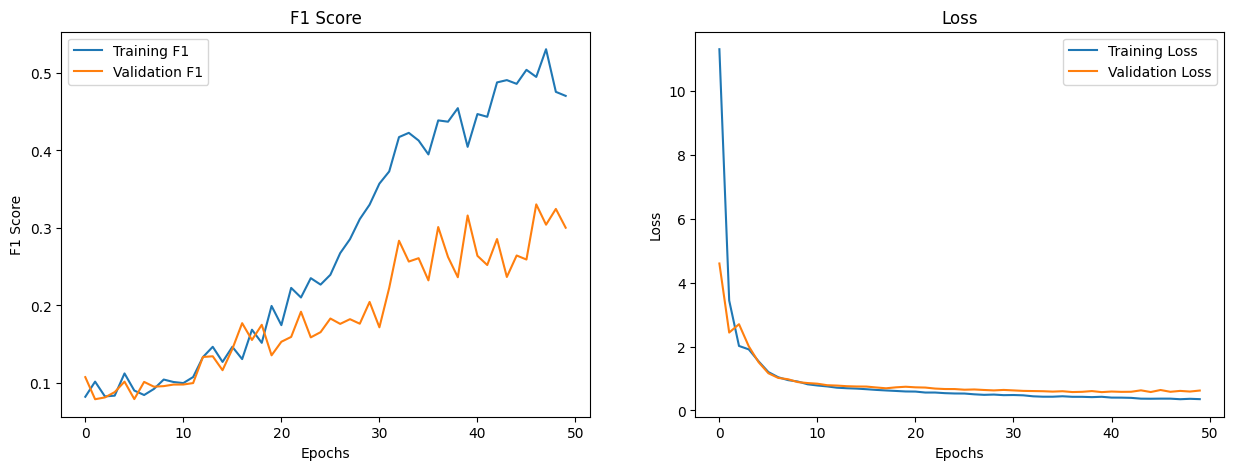

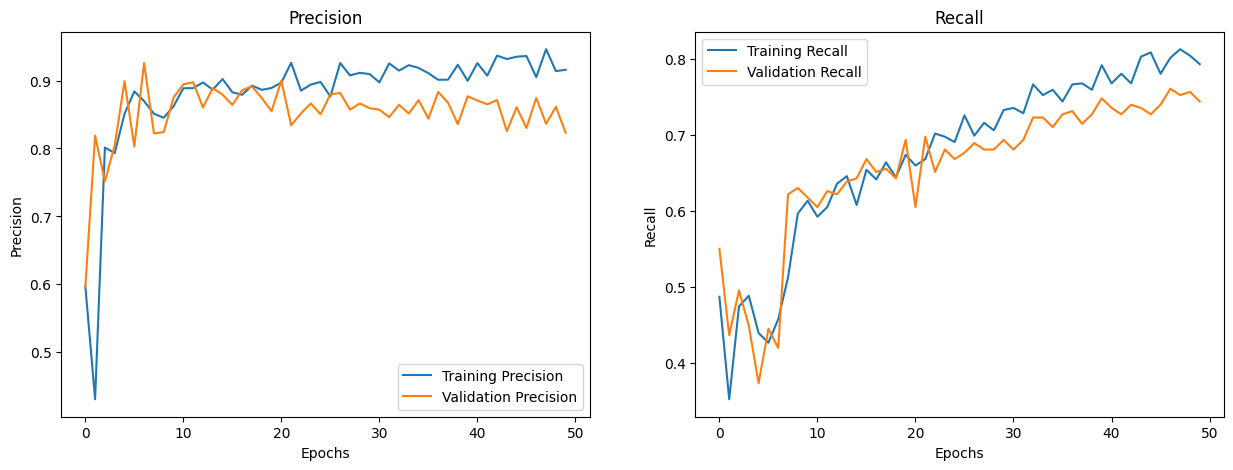

In [238]:
# plots for model 1 + base training set
score = model_base_1.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_base_1.history['f1_score'], label='Training F1')
plt.plot(history_base_1.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_base_1.history['loss'], label='Training Loss')
plt.plot(history_base_1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_base_1.history['precision_16'], label='Training Precision')
plt.plot(history_base_1.history['val_precision_16'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_base_1.history['recall_16'], label='Training Recall')
plt.plot(history_base_1.history['val_recall_16'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [239]:
# model 2 + base training set
model_base_2 = create_cnn_model2(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_2 = model_base_2.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - f1_score: 0.0819 - loss: 12.3644 - precision_17: 0.5497 - recall_17: 0.4804 - val_f1_score: 0.1048 - val_loss: 4.3819 - val_precision_17: 0.5956 - val_recall_17: 0.4580
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 735ms/step - f1_score: 0.1063 - loss: 4.0442 - precision_17: 0.4107 - recall_17: 0.3669 - val_f1_score: 0.0820 - val_loss: 2.7453 - val_precision_17: 0.7469 - val_recall_17: 0.5084
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step - f1_score: 0.0842 - loss: 2.1820 - precision_17: 0.7587 - recall_17: 0.5196 - val_f1_score: 0.0807 - val_loss: 1.9851 - val_precision_17: 0.7500 - val_recall_17: 0.4916
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 744ms/step - f1_score: 0.0807 - loss: 1.6280 - precision_17: 0.7694 - recall_17: 0.4720 - val_f1_score: 0.0682 - val_loss: 1.4130 - val_precision_17: 0.8119 - val_recall_17: 0.3445
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 709ms/step - f1_score: 0.0723 - loss: 1.3356 - precision_17: 0.8673 - recall_17: 0.

F1 Score: 86.14%
Precision: 73.11%
Recall: 19.25%
Loss: 0.5871


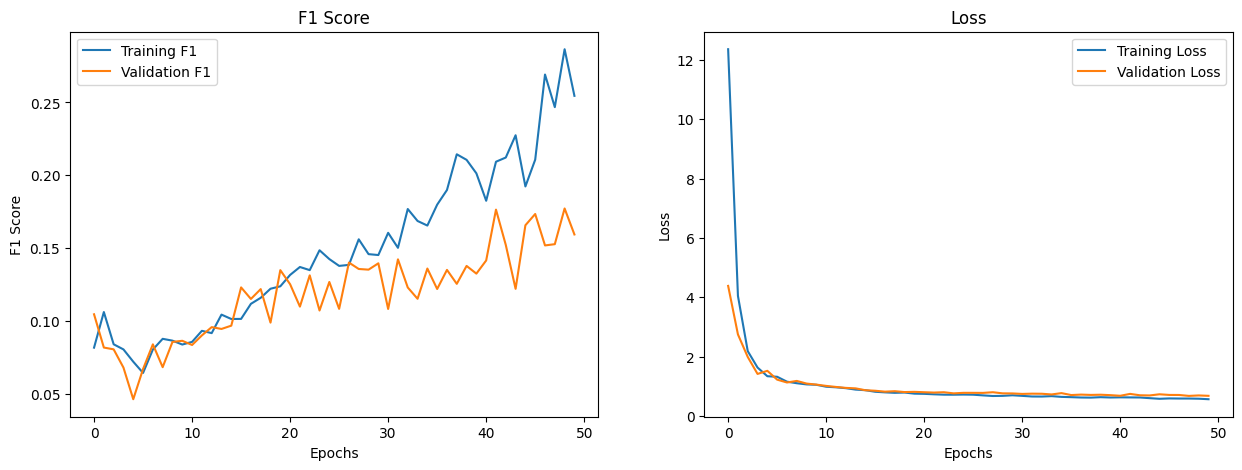

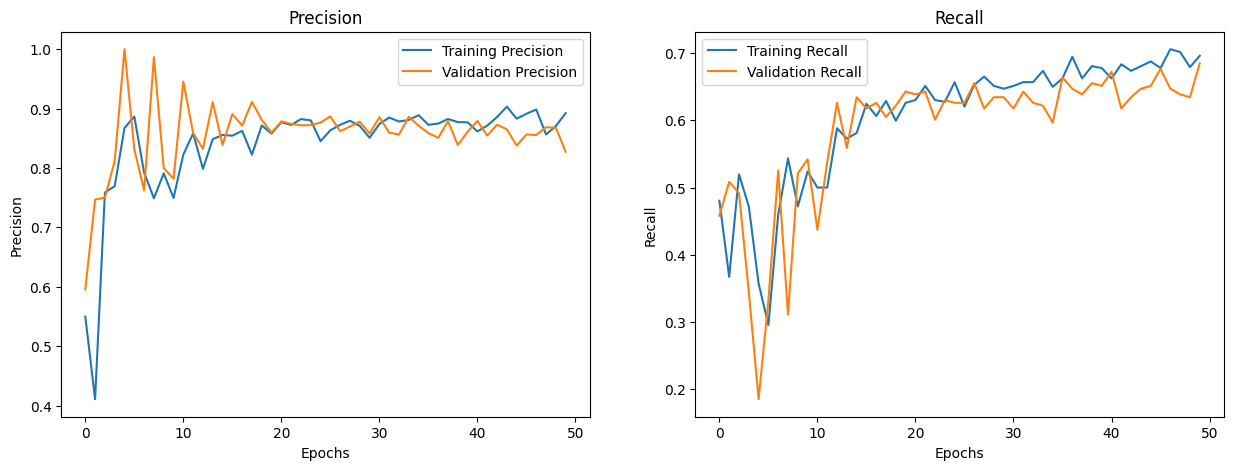

In [240]:
# plots for model 2 + base training set
score = model_base_2.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_base_2.history['f1_score'], label='Training F1')
plt.plot(history_base_2.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_base_2.history['loss'], label='Training Loss')
plt.plot(history_base_2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_base_2.history['precision_17'], label='Training Precision')
plt.plot(history_base_2.history['val_precision_17'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_base_2.history['recall_17'], label='Training Recall')
plt.plot(history_base_2.history['val_recall_17'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [242]:
# model 3 + base training set
model_base_3 = create_cnn_model3(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
history_base_3 = model_base_3.fit(
    base_features_train, 
    train_labels, 
    validation_data=(base_features_val, val_labels), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 885ms/step - f1_score: 0.4780 - loss: 13.2313 - precision_19: 0.5852 - recall_19: 0.4860 - val_f1_score: 0.5267 - val_loss: 5.5272 - val_precision_19: 0.5252 - val_recall_19: 0.5252
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 854ms/step - f1_score: 0.4874 - loss: 3.2657 - precision_19: 0.5073 - recall_19: 0.4370 - val_f1_score: 0.4986 - val_loss: 2.9567 - val_precision_19: 0.5889 - val_recall_19: 0.4454
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - f1_score: 0.5236 - loss: 2.0655 - precision_19: 0.7106 - recall_19: 0.4678 - val_f1_score: 0.4912 - val_loss: 2.0156 - val_precision_19: 0.7852 - val_recall_19: 0.4454
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - f1_score: 0.4808 - loss: 1.5328 - precision_19: 0.8338 - recall_19: 0.4146 - val_f1_score: 0.4392 - val_loss: 1.4459 - val_precision_19: 0.8173 - val_recall_19: 0.3571
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 683ms/step - f1_score: 0.4610 - loss: 1.2469 - precision_19: 0.8754 - recall_19: 0.373

F1 Score: 85.38%
Precision: 76.05%
Recall: 74.99%
Loss: 0.5948


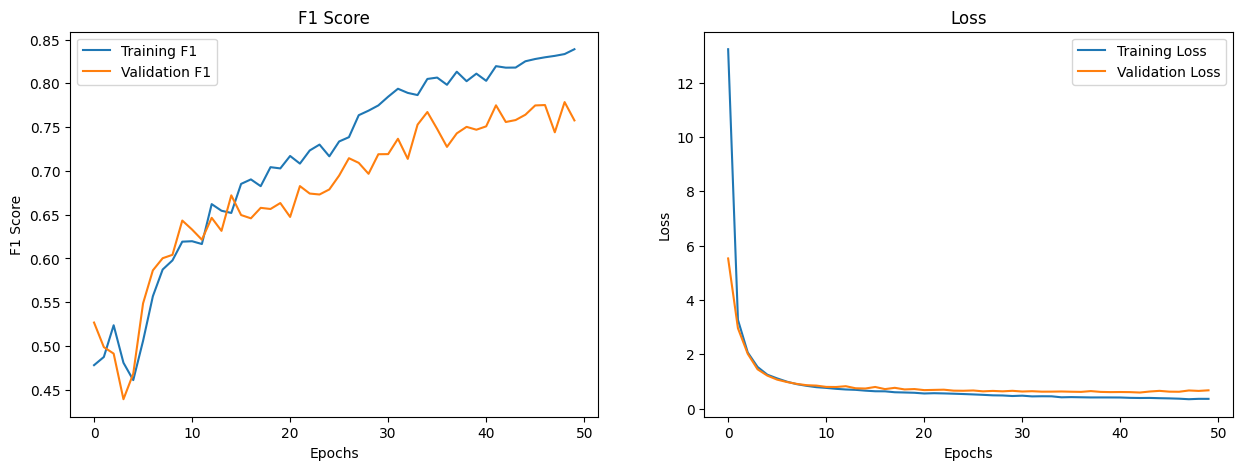

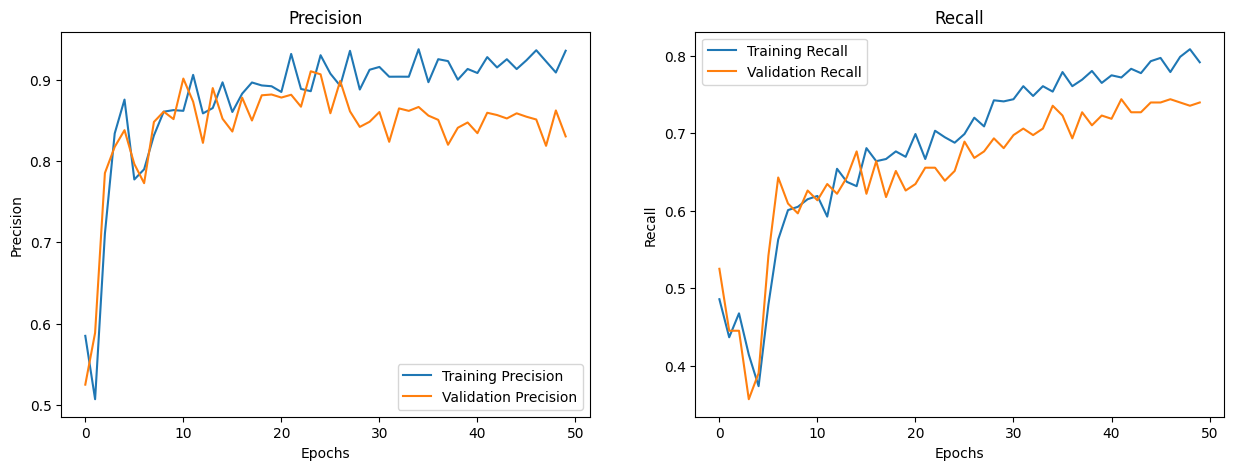

In [243]:
# plots for model 3 + base training set
score = model_base_3.evaluate(base_features_test, test_labels, batch_size=60, verbose=0)
print(f"F1 Score: {score[1]:.2%}")
print(f"Precision: {score[2]:.2%}")
print(f"Recall: {score[3]:.2%}")
print("Loss: {:.4f}".format(score[0]))

# Plot F1 score and loss
plt.figure(figsize=(15, 5))

# F1 Score Plot
plt.subplot(1, 2, 1)
plt.title('F1 Score')
plt.plot(history_base_3.history['f1_score'], label='Training F1')
plt.plot(history_base_3.history['val_f1_score'], label='Validation F1')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.title('Loss')
plt.plot(history_base_3.history['loss'], label='Training Loss')
plt.plot(history_base_3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plt.figure(figsize=(15, 5))

# Precision Score Plot
plt.subplot(1, 2, 1)
plt.title('Precision')
plt.plot(history_base_3.history['precision_19'], label='Training Precision')
plt.plot(history_base_3.history['val_precision_19'], label='Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Recall Score Plot
plt.subplot(1, 2, 2)
plt.title('Recall')
plt.plot(history_base_3.history['recall_19'], label='Training Recall')
plt.plot(history_base_3.history['val_recall_19'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

### EXPERIMENT 1: Audio Distortion

In [ ]:
# model 1 + augmented training set
model_aug_1 = create_cnn_model1(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_1 = model_aug_1.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - f1_score: 0.1256 - loss: 6.3857 - precision_15: 0.4919 - recall_15: 0.4115 - val_f1_score: 0.0754 - val_loss: 1.5060 - val_precision_15: 0.7967 - val_recall_15: 0.4118
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - f1_score: 0.0757 - loss: 1.3588 - precision_15: 0.7974 - recall_15: 0.3545 - val_f1_score: 0.0910 - val_loss: 1.0447 - val_precision_15: 0.7525 - val_recall_15: 0.6261
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - f1_score: 0.0916 - loss: 1.0288 - precision_15: 0.8453 - recall_15: 0.4806 - val_f1_score: 0.0979 - val_loss: 0.8692 - val_precision_15: 0.8492 - val_recall_15: 0.6387
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - f1_score: 0.1065 - loss: 0.9025 - precision_15: 0.8774 - recall_15: 0.5173 - val_f1_score: 0.0977 - val_loss: 0.7843 - val_precision_15: 0.8795 - val_recall_15: 0.6134
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - f1_score: 0.1256 - loss: 0.8344 - precision_15: 0.8785 - recall_15: 0

In [244]:
# model 2 + augmented training set
model_aug_2 = create_cnn_model2(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_2 = model_aug_2.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - f1_score: 0.1172 - loss: 7.1765 - precision_20: 0.4865 - recall_20: 0.4147 - val_f1_score: 0.0774 - val_loss: 2.1173 - val_precision_20: 0.7500 - val_recall_20: 0.4538
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 172ms/step - f1_score: 0.0677 - loss: 1.6546 - precision_20: 0.7968 - recall_20: 0.2895 - val_f1_score: 0.0490 - val_loss: 1.5434 - val_precision_20: 1.0000 - val_recall_20: 0.1975
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 216ms/step - f1_score: 0.0675 - loss: 1.4464 - precision_20: 0.8102 - recall_20: 0.2906 - val_f1_score: 0.0764 - val_loss: 1.2581 - val_precision_20: 0.8235 - val_recall_20: 0.4118
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step - f1_score: 0.0823 - loss: 1.1885 - precision_20: 0.8277 - recall_20: 0.3874 - val_f1_score: 0.0905 - val_loss: 1.1181 - val_precision_20: 0.8411 - val_recall_20: 0.5336
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - f1_score: 0.0943 - loss: 1.0089 - precision_20: 0.8625 - recall_20: 0

In [245]:
# model 3 + augmented training set
model_aug_3 = create_cnn_model3(input_shape=(aug_X_train.shape[1], aug_X_train.shape[2]), n_classes=9)
history_aug_3 = model_aug_3.fit(
    aug_X_train, 
    aug_y_train, 
    validation_data=(aug_X_val, aug_y_val), 
    epochs=50, 
    batch_size=200
)

Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - f1_score: 0.4365 - loss: 6.2814 - precision_21: 0.5441 - recall_21: 0.4099 - val_f1_score: 0.2865 - val_loss: 1.9912 - val_precision_21: 0.4065 - val_recall_21: 0.2101
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - f1_score: 0.4001 - loss: 1.3422 - precision_21: 0.8140 - recall_21: 0.3162 - val_f1_score: 0.5188 - val_loss: 1.0439 - val_precision_21: 0.8908 - val_recall_21: 0.4454
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - f1_score: 0.5170 - loss: 0.9772 - precision_21: 0.8823 - recall_21: 0.4827 - val_f1_score: 0.6548 - val_loss: 0.8594 - val_precision_21: 0.8398 - val_recall_21: 0.6387
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - f1_score: 0.5629 - loss: 0.8477 - precision_21: 0.8780 - recall_21: 0.5351 - val_f1_score: 0.6474 - val_loss: 0.8030 - val_precision_21: 0.8779 - val_recall_21: 0.6345
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 168ms/step - f1_score: 0.5719 - loss: 0.8323 - precision_21: 0.8490 - recall_21: 0

### EXPERIMENT 2: Training of specific locations

In [246]:
locations = ['Anterior','Posterior']

results_locations_1 = {}
history_location_1_dict = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_1 = create_cnn_model1(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history_location_1 = model_location_1.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )
    history_location_1_dict[loc] = history_location_1.history

    score = model_location_1.evaluate(location_features_test, y_test, verbose=0)
    results_locations_1[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }

Training on Anterior


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - f1_score: 0.0992 - loss: 9.8915 - precision_22: 0.5152 - recall_22: 0.4734 - val_f1_score: 0.0948 - val_loss: 6.0408 - val_precision_22: 0.3496 - val_recall_22: 0.3319
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - f1_score: 0.1209 - loss: 3.4561 - precision_22: 0.5187 - recall_22: 0.4664 - val_f1_score: 0.0827 - val_loss: 3.8978 - val_precision_22: 0.7531 - val_recall_22: 0.5126
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - f1_score: 0.0862 - loss: 2.3084 - precision_22: 0.8088 - recall_22: 0.4384 - val_f1_score: 0.0801 - val_loss: 1.8703 - val_precision_22: 0.7914 - val_recall_22: 0.4622
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 227ms/step - f1_score: 0.0847 - loss: 1.3300 - precision_22: 0.7848 - recall_22: 0.4496 - val_f1_score: 0.0821 - val_loss: 1.4257 - val_precision_22: 0.7628 - val_recall_22: 0.5000
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - f1_score: 0.0881 - loss: 1.1588 - precision_22: 0.7692 - recall_22: 0.5322 - va

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 230ms/step - f1_score: 0.0887 - loss: 13.2397 - precision_23: 0.6353 - recall_23: 0.5196 - val_f1_score: 0.0827 - val_loss: 5.6169 - val_precision_23: 0.7043 - val_recall_23: 0.5504
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - f1_score: 0.1008 - loss: 2.5152 - precision_23: 0.6533 - recall_23: 0.4328 - val_f1_score: 0.0848 - val_loss: 1.6433 - val_precision_23: 0.6832 - val_recall_23: 0.2899
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - f1_score: 0.0881 - loss: 1.4272 - precision_23: 0.8476 - recall_23: 0.3739 - val_f1_score: 0.0766 - val_loss: 1.4991 - val_precision_23: 0.8065 - val_recall_23: 0.4202
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - f1_score: 0.0786 - loss: 1.2829 - precision_23: 0.8530 - recall_23: 0.4146 - val_f1_score: 0.0733 - val_loss: 1.2238 - val_precision_23: 0.8273 - val_recall_23: 0.3824
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - f1_score: 0.0780 - loss: 1.0696 - precision_23: 0.8679 - recall_23: 0.4048 - v

In [247]:
results_locations_2 = {}
history_location_2_dict = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_2 = create_cnn_model2(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history_location_2 = model_location_2.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )
    history_location_2_dict[loc] = history_location_2.history

    score = model_location_2.evaluate(location_features_test, y_test, verbose=0)
    results_locations_2[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }

Training on Anterior


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - f1_score: 0.0988 - loss: 13.6604 - precision_24: 0.5948 - recall_24: 0.5098 - val_f1_score: 0.1022 - val_loss: 5.7991 - val_precision_24: 0.5169 - val_recall_24: 0.5126
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - f1_score: 0.1042 - loss: 3.7734 - precision_24: 0.5090 - recall_24: 0.4342 - val_f1_score: 0.0730 - val_loss: 1.7842 - val_precision_24: 0.8070 - val_recall_24: 0.3866
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - f1_score: 0.0755 - loss: 1.5703 - precision_24: 0.8208 - recall_24: 0.3978 - val_f1_score: 0.0586 - val_loss: 1.5500 - val_precision_24: 0.8630 - val_recall_24: 0.2647
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - f1_score: 0.0683 - loss: 1.4543 - precision_24: 0.8755 - recall_24: 0.3249 - val_f1_score: 0.0513 - val_loss: 1.5286 - val_precision_24: 0.9273 - val_recall_24: 0.2143
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - f1_score: 0.0697 - loss: 1.3423 - precision_24: 0.8727 - recall_24: 0.3361 - v

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 250ms/step - f1_score: 0.1079 - loss: 16.9146 - precision_25: 0.5951 - recall_25: 0.5084 - val_f1_score: 0.0825 - val_loss: 6.2655 - val_precision_25: 0.7381 - val_recall_25: 0.5210
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - f1_score: 0.0934 - loss: 4.5816 - precision_25: 0.5988 - recall_25: 0.4076 - val_f1_score: 0.0700 - val_loss: 1.8586 - val_precision_25: 0.8173 - val_recall_25: 0.3571
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step - f1_score: 0.0767 - loss: 1.7649 - precision_25: 0.8482 - recall_25: 0.3992 - val_f1_score: 0.0658 - val_loss: 1.4457 - val_precision_25: 0.8191 - val_recall_25: 0.3235
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - f1_score: 0.0745 - loss: 1.3498 - precision_25: 0.8673 - recall_25: 0.3754 - val_f1_score: 0.0658 - val_loss: 1.3543 - val_precision_25: 0.8810 - val_recall_25: 0.3109
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - f1_score: 0.0753 - loss: 1.2042 - precision_25: 0.8445 - recall_25: 0.3880 - v

In [248]:
results_locations_3 = {}
history_location_3_dict = {}

for loc in locations:
    print(f'Training on {loc}')
    filtered_paths = [p for p in audio_paths if extract_location_metadata(p) == loc]
    filtered_labels = [labels[i] for i, p in enumerate(audio_paths) if extract_location_metadata(p) == loc]

    train_paths, test_paths, y_train, y_test = train_test_split(
        filtered_paths, filtered_labels, test_size=0.2, random_state=42, stratify=filtered_labels
    )
    train_paths, val_paths, y_train, y_val = train_test_split(
        train_paths, y_train, test_size=0.25, random_state=42, stratify=y_train
    )

    location_features_train = np.array(extract_basic_model_features(train_paths))
    location_features_val = np.array(extract_basic_model_features(val_paths))
    location_features_test = np.array(extract_basic_model_features(test_paths))

    y_train = to_categorical(y_train, num_classes=9)
    y_val = to_categorical(y_val,num_classes=9)
    y_test = to_categorical(y_test,num_classes=9)

    model_location_3 = create_cnn_model3(input_shape=(base_features_train.shape[1], base_features_train.shape[2]), n_classes=9)
    history_location_3= model_location_3.fit(
        base_features_train, 
        train_labels, 
        validation_data=(base_features_val, val_labels), 
        epochs=50, 
        batch_size=200
    )
    history_location_3_dict[loc] = history_location_3.history

    score = model_location_3.evaluate(location_features_test, y_test, verbose=0)
    results_locations_3[loc] = {
        "loss": score[0],
        "precision": score[1],
        "recall": score[2],
        "f1_score": score[3]
    }

Training on Anterior


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - f1_score: 0.4826 - loss: 11.7497 - precision_26: 0.5668 - recall_26: 0.4930 - val_f1_score: 0.5255 - val_loss: 6.3415 - val_precision_26: 0.5687 - val_recall_26: 0.5042
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 282ms/step - f1_score: 0.4780 - loss: 4.8515 - precision_26: 0.5639 - recall_26: 0.4020 - val_f1_score: 0.4982 - val_loss: 3.2852 - val_precision_26: 0.7746 - val_recall_26: 0.4622
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - f1_score: 0.4961 - loss: 2.3825 - precision_26: 0.8191 - recall_26: 0.4440 - val_f1_score: 0.4480 - val_loss: 1.7715 - val_precision_26: 0.8148 - val_recall_26: 0.3697
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - f1_score: 0.4633 - loss: 1.4519 - precision_26: 0.8870 - recall_26: 0.3739 - val_f1_score: 0.4059 - val_loss: 1.3419 - val_precision_26: 0.9103 - val_recall_26: 0.2983
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 355ms/step - f1_score: 0.4616 - loss: 1.2025 - precision_26: 0.8949 - recall_26: 0.3697 - v

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Epoch 1/50


/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - f1_score: 0.4672 - loss: 11.1174 - precision_27: 0.5249 - recall_27: 0.4426 - val_f1_score: 0.3074 - val_loss: 5.3964 - val_precision_27: 0.2773 - val_recall_27: 0.2773
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - f1_score: 0.5050 - loss: 3.4183 - precision_27: 0.4853 - recall_27: 0.4608 - val_f1_score: 0.5566 - val_loss: 2.8984 - val_precision_27: 0.7232 - val_recall_27: 0.5378
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - f1_score: 0.5469 - loss: 2.0873 - precision_27: 0.7669 - recall_27: 0.5252 - val_f1_score: 0.4972 - val_loss: 1.3546 - val_precision_27: 0.7883 - val_recall_27: 0.4538
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - f1_score: 0.4639 - loss: 1.2531 - precision_27: 0.8503 - recall_27: 0.3739 - val_f1_score: 0.4979 - val_loss: 1.1488 - val_precision_27: 0.8092 - val_recall_27: 0.4454
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - f1_score: 0.5277 - loss: 1.0641 - precision_27: 0.8138 - recall_27: 0.4958 - v

# Appendix

1. We based our intial architecture for our CNN and CNN plots (like loss) off of this code: https://www.kaggle.com/code/markdenton/cnn-disease-classification-linked-features-95


2. Used ChatGPT free version to help format the input array for our CNN models:
    `padded = padded[..., np.newaxis]`